# Step 1: El simple y viejo Train / Test

In [1]:
# Limpiamos el entorno
rm(list = ls())
gc(verbose = FALSE)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,627610,33.6,1404620,75.1,994508,53.2
Vcells,1149700,8.8,8388608,64.0,1769393,13.5


In [2]:
# Librerías necesarias
require("data.table")
require("rpart")
require("ROCR")
require("ggplot2")
require("caret")

Loading required package: data.table

Loading required package: rpart



Loading required package: ROCR

Loading required package: ggplot2

Loading required package: caret

Loading required package: lattice



In [3]:
# Aqui se debe poner la carpeta de la materia de SU computadora local
setwd("C:/Users/German/Desktop/dmeyf2023/German/Clase 1") # Establezco el Working Directory

# Poner sus semillas
semillas <- c(279511, 279523, 279541, 279551, 279571)

# Cargamos el dataset
dataset <- fread("competencia_01_alternativo.csv")
dtrain <- dataset[foto_mes == 202103]

In [4]:
# Nos quedamos solo con el 202101
dataset <- dataset[foto_mes == 202103]
# Creamos una clase binaria
dataset[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]
# Borramos el target viejo
dataset[, clase_ternaria := NULL]

In [5]:
# Seteamos nuestra primera semilla
set.seed(semillas[1])

In [6]:
# Particionamos de forma estratificada
in_training <- caret::createDataPartition(dataset$clase_binaria,
                     p = 0.70, list = FALSE) 
dtrain  <-  dataset[in_training, ]
dtest   <-  dataset[-in_training, ]

 Preguntas
 - ¿Por qué separamos en train/test?
 - ¿Son números aleatorios los que nos dan las computadoras?
 - ¿Por qué usamos semillas?
 - ¿Qué es una partición estratificada?
 - ¿Tiene realemente alguna ventaja la partición estratificada ?

# Step 2: Armando el primer modelo particionado

In [7]:
# Medimos cuanto tarda nuestro modelo en ajustar
start_time <- Sys.time()
modelo <- rpart(clase_binaria ~ .,
                data = dtrain,
                xval = 0,
                cp = 0,
                minsplit = 20,
                minbucket = 1,
                maxdepth = 5)
print(Sys.time() - start_time)

Time difference of 5.093808 secs


In [8]:
pred_testing <- predict(modelo, dtest, type = "prob")

 Preguntas:
 - ¿Qué tan importante mirar las métricas de train?

# Step 3: Mirando la ganancia

In [9]:
# Armamos una función que nos calcule la ganancia, usando el punto de corte de 0.025
ganancia <- function(probabilidades, clase) {
  return(sum(
    (probabilidades >= 0.025) * ifelse(clase == "evento", 273000, -7000))
  )
}

In [10]:
# La ganancia en testing NORMALIZADA
print(ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3)

[1] 58776667


`Actividad`:
Comparta el número que le dio de ganancia y cuanto error estima que puede haber con el resto de sus compañeros


# Step 4: Probando más muchas más semillas

In [11]:
# Almacenaremos los resultados en una tabla
resultados_n_gan <- c()

Calcule en función del tiempo de ejecución anterior, cuantos árboles puede hacer en 5 minutos y ponga ese número en la siguiente variable "n"

In [12]:
n <- 100

In [13]:
set.seed(semillas[1])
t0 <- Sys.time()
for (i in 1:n) {

    in_training <- caret::createDataPartition(dataset[, get("clase_binaria")],
                            p = 0.70, list = FALSE)
    dtrain  <-  dataset[in_training, ]
    dtest   <-  dataset[-in_training, ]

    modelo <- rpart(clase_binaria ~ .,
                    data = dtrain,
                    xval = 0,
                    cp = 0,
                    minsplit = 20,
                    minbucket = 1,
                    maxdepth = 5)

    pred_testing <- predict(modelo, dtest, type = "prob")

    gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3

    resultados_n_gan <- c(resultados_n_gan, gan)
}
print(Sys.time() - t0)


Time difference of 7.812371 mins


 Preguntas:
 ¿Cree que puede cambiar mucho la ganancia en **test** para dos semillas distintas?


# Step 5: Analizando el azar de las semillas

In [14]:
# La menor ganancia conseguida en test
print(min(resultados_n_gan))

# La mayor ganancia
print(max(resultados_n_gan))

# La media de la ganancia
print(mean(resultados_n_gan))

[1] 39736667
[1] 70840000
[1] 54718300


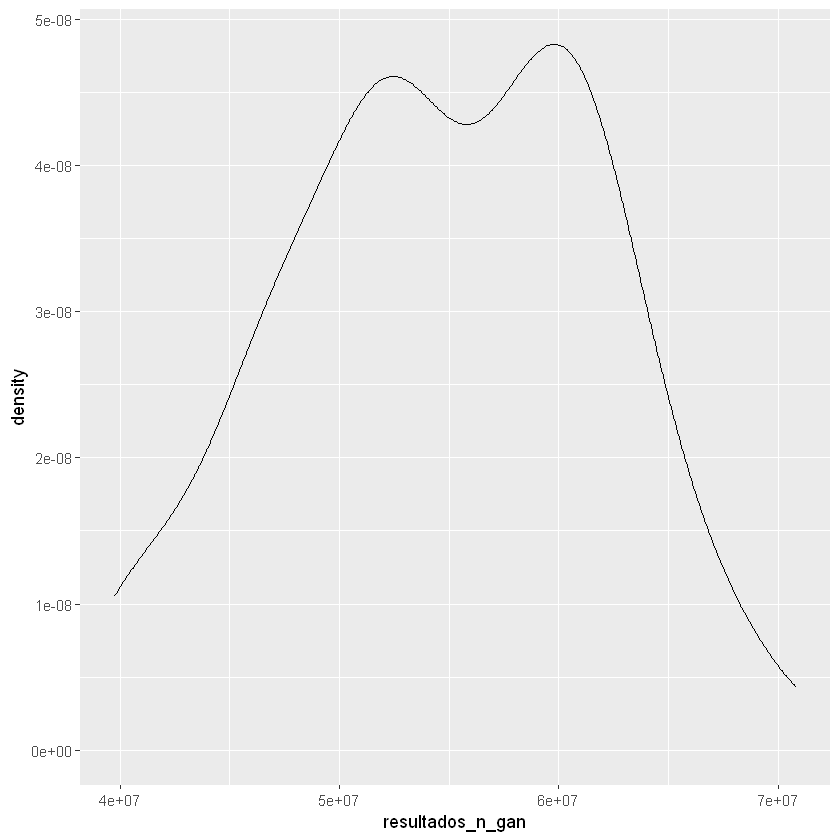

In [15]:
# Veamos la dispersión de la ganancia
ggplot() + aes(resultados_n_gan) + geom_density()

# Step 6: Tratando de corregir la dispersión

In [16]:
# Veamos si tomar el promedio de 5 árboles nos ayuda a reducir la dispersión
cantidad_arboles <- 5

resultados_n_mcv <- c()
set.seed(semillas[1])

for (i in 1:50) 
    resultados_n_mcv <- c(resultados_n_mcv, mean(sample(resultados_n_gan, cantidad_arboles)))

In [17]:
# La menor ganancia conseguida en test
print(min(resultados_n_mcv))

# La mayor ganancia
print(max(resultados_n_mcv))

# La media de la ganancia
print(mean(resultados_n_mcv))

[1] 49410667
[1] 62216000
[1] 55438880


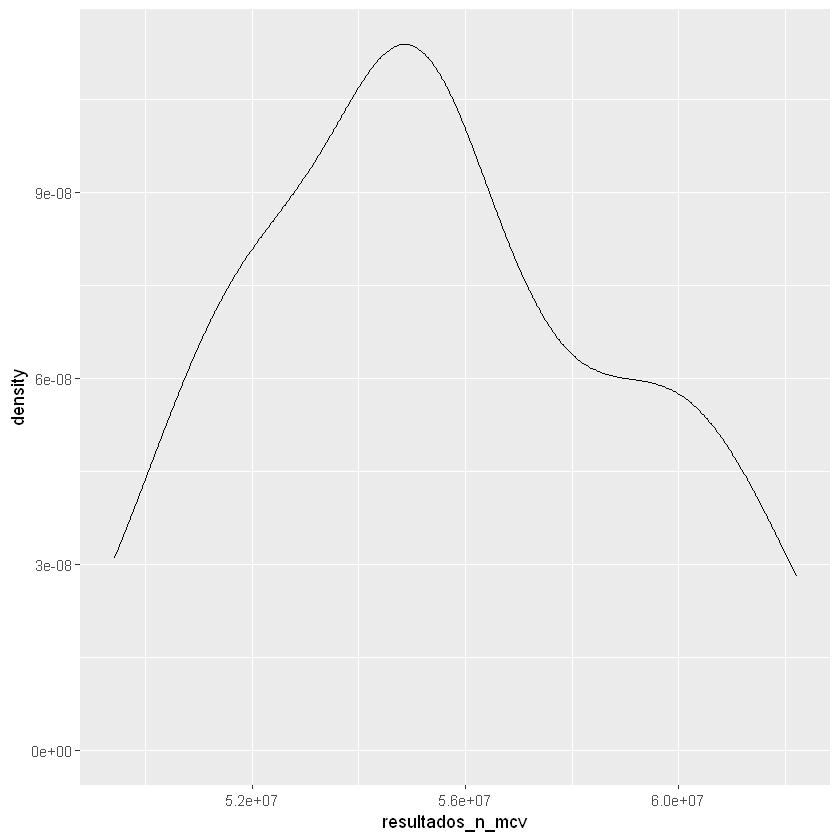

In [18]:
# Veamos la dispersión de la ganancia
ggplot() + aes(resultados_n_mcv) + geom_density()

`NOTA`: Esta técnica es conocida como Montecarlo Cross Validation
 Preguntas
 - ¿Qué efecto observa cuando se toma como medición el promedio de 5 árboles?
 - ¿Desapareció el error?
 - ¿Si se hubieran tomado más valores que efectos esperaría?
 - ¿Que ventaja y desventaja ve en esta técnica comparada al Cross Validation?

# Step 7: Midiendo nuestras semillas

In [19]:
resultados_mis_semillas <- c()

t0 <- Sys.time()
for (s in semillas) {
    set.seed(s)
    in_training <- caret::createDataPartition(dataset[, get("clase_binaria")],
                            p = 0.70, list = FALSE)
    dtrain  <-  dataset[in_training, ]
    dtest   <-  dataset[-in_training, ]

    modelo <- rpart(clase_binaria ~ .,
                    data = dtrain,
                    xval = 0,
                    cp = 0,
                    minsplit = 20,
                    minbucket = 1,
                    maxdepth = 5)

    pred_testing <- predict(modelo, dtest, type = "prob")

    gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3

    resultados_mis_semillas <- c(resultados_mis_semillas, gan)

}
print(Sys.time() - t0)

Time difference of 24.96958 secs


In [20]:
print(mean(resultados_mis_semillas))

[1] 53074000


Preguntas
 - ¿Cuán lejos se encontró la media de sus semillas respecto a los resultados anteriores?
 - ¿Usaría semillas que le den un valor promedio más alto?
 - ¿Usaría más semillas?
 - ¿Que ventaja y desventaja ve en usar más semillas?

# Step 8: Buscando un mejor modelo (Grid Search)

## Estrategia de la clase

In [21]:
resultados_grid_search <- data.table()

 Complete los valores que se van a combinar para cada parámetro a explorar

In [22]:
for (cp in c(-1, 0.01)) { 
for (md in c(5, 10, 15, 30)) {
for (ms in c(1, 50, 500, 1000)) {
for (mb in c(1, as.integer(ms / 2))) {

    t0 <- Sys.time()
    gan_semillas <- c()
    for (s in semillas) {
        set.seed(s)
        in_training <- caret::createDataPartition(dataset[,
                        get("clase_binaria")],
                                p = 0.70, list = FALSE)
        dtrain  <-  dataset[in_training, ]
        dtest   <-  dataset[-in_training, ]

        modelo <- rpart(clase_binaria ~ .,
                        data = dtrain,
                        xval = 0,
                        cp = cp,
                        minsplit = ms,
                        minbucket = mb,
                        maxdepth = md)

        pred_testing <- predict(modelo, dtest, type = "prob")
        gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3

        gan_semillas <- c(gan_semillas, gan)
    }
    tiempo <-  as.numeric(Sys.time() - t0, units = "secs")

    resultados_grid_search <- rbindlist(list(
                                resultados_grid_search,
                                data.table(
                                    tiempo = tiempo,
                                    cp = cp,
                                    mb = mb,
                                    ms = ms,
                                    md = md,
                                    gan = mean(gan_semillas)) # se puede agregar el sd?
                                ))
}
}
}
}

# Visualizo los parámetros de los mejores parámetros
print(resultados_grid_search[gan == max(gan), ])

     tiempo cp mb ms md      gan
1: 22.93221 -1 25 50  5 67214000


In [23]:
#  Imprimo todas ordenadas por mayor ganancia
print(resultados_grid_search[order(-resultados_grid_search$gan), ])


      tiempo    cp  mb   ms md      gan
 1: 22.93221 -1.00  25   50  5 67214000
 2: 25.86321 -1.00 500 1000  5 66206000
 3: 25.21487 -1.00 250  500  5 64134000
 4: 46.93531 -1.00 500 1000 10 63821333
 5: 44.28603 -1.00 500 1000 15 63821333
 6: 35.11789 -1.00 500 1000 30 63821333
 7: 59.55467 -1.00   1 1000 15 63550667
 8: 39.33842 -1.00   1 1000 10 63163333
 9: 41.98935 -1.00   1    1 10 61007333
10: 34.99153 -1.00   0    1 10 61007333
11: 39.56204 -1.00   1  500 10 59990000
12: 35.14319 -1.00   1   50 10 59798667
13: 41.70184 -1.00 250  500 10 58580667
14: 64.11355 -1.00   1  500 15 57908667
15: 46.64285 -1.00 250  500 15 56415333
16: 44.71463 -1.00 250  500 30 56415333
17: 23.87602 -1.00   1   50  5 54810000
18: 73.71284 -1.00   1 1000 30 54800667
19: 30.21361 -1.00   1 1000  5 54679333
20: 26.50836 -1.00   1  500  5 54614000
21: 34.07819 -1.00   1    1  5 54506667
22: 24.20487 -1.00   0    1  5 54506667
23: 55.39456 -1.00   1   50 15 51300667
24: 55.83838 -1.00   1    1 15 49387333


## Estrategia propia de Search:

Random Search:

In [24]:
# Definir los rangos de parámetros
cp_range <- runif(20, -1, 1)  # 20 Valores aleatorios entre -1 y 1 (incluyendo valores negativos)
md_range <- sample(c(3, 5, 10, 15, 20, 25, 30), 20, replace = TRUE)  # Muestreo aleatorio
ms_range <- sample(c(1, 10, 50, 100, 200, 500, 1000), 20, replace = TRUE)  # Muestreo aleatorio
mb_range <- sapply(ms_range, function(ms) sample(c(1, as.integer(ms / 2), as.integer(ms / 3), ms / 4), 1)) 



resultados_random_search <- data.table()

for (i in 1:length(cp_range)) {
    cp <- cp_range[i]
    md <- md_range[i]
    ms <- ms_range[i]
    mb <- mb_range[i]

    t0 <- Sys.time()
    gan_semillas <- c()

    for (s in semillas) {
        set.seed(s)
        in_training <- caret::createDataPartition(dataset[, get("clase_binaria")], p = 0.70, list = FALSE)
        dtrain <- dataset[in_training, ]
        dtest <- dataset[-in_training, ]

        modelo <- rpart(clase_binaria ~ .,
                        data = dtrain,
                        xval = 0,
                        cp = cp,
                        minsplit = ms,
                        minbucket = mb,
                        maxdepth = md)

        pred_testing <- predict(modelo, dtest, type = "prob")
        gan <- ganancia(pred_testing[, "evento"], dtest$clase_binaria) / 0.3
        gan_semillas <- c(gan_semillas, gan)
    }

    tiempo <- as.numeric(Sys.time() - t0, units = "secs")

    resultados_random_search <- rbindlist(list(
        resultados_random_search,
        data.table(
            tiempo = tiempo,
            cp = cp,
            mb = mb,
            ms = ms,
            md = md,
            gan = mean(gan_semillas))
    ))
}

# Ordenar resultados por mayor ganancia
resultados_random_search <- resultados_random_search[order(-gan)]

In [25]:
print(resultados_random_search[order(-resultados_random_search$gan), ])


       tiempo          cp  mb   ms md      gan
 1: 24.649142 -0.33690335  25  100  5 66957333
 2: 36.169378 -0.06237259 333 1000 15 66154667
 3: 38.914521 -0.22159424   1  200 10 59915333
 4: 47.734662 -0.40862373 166  500 10 56980000
 5: 19.665049 -0.29497312  33  100  3 55314000
 6: 43.155942 -0.04792929 166  500 20 54119333
 7: 17.356111 -0.18121764   1   50  3 53942000
 8: 66.154792 -0.58206624   1  200 25 38000667
 9: 61.766898 -0.44497119  25  100 15 30566667
10: 56.893091 -0.24122567  25   50 30 21149333
11: 15.550057  0.11269134   0    1  5        0
12: 10.940676  0.34985704 100  200  5        0
13: 11.761172  0.36556193 250 1000 20        0
14: 10.695918  0.43216212   3   10 10        0
15: 10.065611  0.41893374  25  100 30        0
16: 12.107230  0.63833750   1  500 20        0
17:  9.949776  0.80506148 166  500 25        0
18:  9.785949  0.67257368   1    1  5        0
19:  9.743428  0.67150564 500 1000 20        0
20: 10.477587  0.30042240  25   50  3        0


Salida Chatgpt

cp (Complexity Parameter):

El parámetro de complejidad controla la poda del árbol de decisión para evitar el sobreajuste.
Valores más grandes de cp generan árboles más pequeños y menos complejos.
Valores negativos generalmente no tienen sentido, ya que indicarían una penalización inversa a la complejidad.
Rango razonable: De 0 a 0.1. Un rango más amplio podría incluir valores negativos, pero suele ser poco común y puede no tener un significado claro en este contexto.

md (Max Depth):

La profundidad máxima del árbol de decisión, es decir, la longitud máxima desde la raíz hasta una hoja.
Valores más bajos previenen el sobreajuste, mientras que valores más altos pueden llevar al sobreajuste.
Rango razonable: De 3 a 30. Esto permite árboles relativamente cortos y también árboles más profundos.

ms (Min Split):

El número mínimo de observaciones requeridas en un nodo para que se pueda dividir en subnodos.
Valores más bajos permiten divisiones incluso en conjuntos pequeños, lo que puede conducir al sobreajuste.
Rango razonable: De 1 a la mitad del tamaño del conjunto de datos. Esto permitirá una amplia variedad de tamaños de nodo.

mb (Min Bucket):

El número mínimo de observaciones requeridas en una hoja (bucket) después de una división.
Valores más bajos pueden conducir a hojas con pocos ejemplos, lo que podría resultar en sobreajuste.
Rango razonable: De 1 a la mitad del tamaño del conjunto de datos. Al igual que con ms, esto permitirá una variedad de tamaños de hoja.

Es importante señalar que los rangos de valores dependerán en gran medida de la naturaleza de tus datos y del problema en cuestión. Siempre es recomendable realizar pruebas con diferentes valores y observar cómo afectan al rendimiento del modelo en función de métricas relevantes, como la precisión, el recall o la ganancia.

# TAREA:

`TAREA`:
- Una vez que tenga sus mejores parámetros, haga una copia del script rpart/z101_PrimerModelo.R, cambie los parámetros dentro del script, ejecutelo y suba a Kaggle su modelo.

`Preguntas`:
- ¿Cuál es la diferencia entre **test** y **validation**?
- ¿Cuántas veces podemos usar el conjunto de **test** sin convertirlo en **validation**?

`La GRAN pregunta`:
 - ¿Qué otra cosita de la materia tiene una partición 70 / 30?
 - Todo lo que hemos visto ¿Va a afectar a esa cosita?.